In [71]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



In [72]:

# Verzeichnis mit CSV-Dateien
file_path_pattern = r'..\..\..\data\attitude_roots_disapere\*.csv'

# Alle CSV-Dateien im Verzeichnis finden
csv_files = glob.glob(file_path_pattern)

# CSV-Dateien zu einem DataFrame kombinieren
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df = combined_df[['text', 'aspect']]
df = df.rename(columns={'aspect': 'labels', 'text': 'data'})
df = df.drop_duplicates(keep='first')

# Mindestlänge: mindestens 3 Worte
df = df[df['data'].apply(lambda x: len(str(x).split()) >= 3)]



print(len(df))


9129


In [73]:
# Zuerst in Trainings- und Testdaten aufteilen, bevor resampling durchgeführt wird
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

In [74]:
# Nun führen wir das Resampling nur auf den Trainingsdaten durch
aspects = [
    "asp_substance",
    "asp_originality",
    "asp_clarity",
    "asp_soundness-correctness",
    "asp_motivation-impact",
    "asp_meaningful-comparison",
    "asp_replicability",
    "arg_other"
]

for aspect in aspects:
    aspect_subset = train_df[train_df["labels"] == aspect]
    # Beispielsweise: resample identisch groß, aber Sie könnten das n anpassen, wenn nötig
    if len(aspect_subset) > 0:
        resampled = aspect_subset.sample(n=len(aspect_subset), replace=True, random_state=42)
        train_df = pd.concat([train_df, resampled], ignore_index=True)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

print("Train Labels:", train_df["labels"].unique())
print("Test Labels:", test_df["labels"].unique())


Train size: 12155
Test size: 1370
Train Labels: ['none' 'asp_originality' 'asp_clarity' 'asp_substance'
 'asp_replicability' 'asp_motivation-impact' 'asp_soundness-correctness'
 'asp_meaningful-comparison' 'arg_other']
Test Labels: ['asp_soundness-correctness' 'none' 'asp_substance'
 'asp_meaningful-comparison' 'asp_clarity' 'asp_motivation-impact'
 'asp_replicability' 'arg_other' 'asp_originality']


In [75]:
# Zähle, wie oft jede Klasse in den Trainingsdaten vorkommt
class_counts = train_df['labels'].value_counts()

# Ausgabe der Häufigkeiten jeder Klasse
print("Class distribution in training data:")
print(class_counts)

Class distribution in training data:
labels
none                         3363
asp_substance                2866
asp_clarity                  1832
asp_soundness-correctness    1648
asp_originality               634
asp_motivation-impact         620
asp_meaningful-comparison     504
asp_replicability             470
arg_other                     218
Name: count, dtype: int64


In [76]:
# Mapping für die Trainingsdaten
train_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(train_df["labels"].astype("category").cat.categories)),
    'labels': train_df["labels"].astype("category").cat.categories
})

print("Train Mapping:\n", train_mapping_df)

Train Mapping:
    encoded_cat                     labels
0            0                  arg_other
1            1                asp_clarity
2            2  asp_meaningful-comparison
3            3      asp_motivation-impact
4            4            asp_originality
5            5          asp_replicability
6            6  asp_soundness-correctness
7            7              asp_substance
8            8                       none


In [77]:
# Encode labels in train_df
train_df["encoded_cat"] = train_df["labels"].astype("category").cat.codes
train_texts = train_df["data"].to_list()  # Features (not tokenized yet)
train_labels = train_df["encoded_cat"].to_list()  # Labels

# Für Testdaten separat encodieren, um Konsistenz sicherzustellen
test_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(test_df["labels"].astype("category").cat.categories)),
    'labels': test_df["labels"].astype("category").cat.categories
})
print("Test Mapping:\n", test_mapping_df)


Test Mapping:
    encoded_cat                     labels
0            0                  arg_other
1            1                asp_clarity
2            2  asp_meaningful-comparison
3            3      asp_motivation-impact
4            4            asp_originality
5            5          asp_replicability
6            6  asp_soundness-correctness
7            7              asp_substance
8            8                       none


In [78]:
test_df["encoded_cat"] = test_df["labels"].astype("category").cat.codes
data_test_texts = test_df["data"].to_list()  # Features (not tokenized yet)
data_test_labels = test_df["encoded_cat"].to_list()  # Labels

# Optional: weitere Aufteilung von Testdaten in Validation und finalen Test, wenn gewünscht.
val_texts, final_test_texts, val_labels, final_test_labels = train_test_split(
    data_test_texts, data_test_labels, test_size=0.9, random_state=0, shuffle=True
)


In [79]:
import tensorflow as tf
#Daten tokenisieren
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [80]:
# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
# import tensorflow as tf

# # Pfad zum Modell und Tokenizer
# model_path = r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\final_model"

# # Tokenizer und Modell laden
# tokenizer = DistilBertTokenizer.from_pretrained(model_path)
# model = TFDistilBertForSequenceClassification.from_pretrained(model_path, num_labels=9)

# # Optimizer einstellen
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

# # Modell kompilieren
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# print("Tokenizer and model loaded and compiled successfully!")


In [81]:
# Tokenisierung
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
final_test_encodings = tokenizer(final_test_texts, truncation=True, padding=True)

# Tensoren erstellen
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
final_test_labels = tf.convert_to_tensor(final_test_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(final_test_encodings), final_test_labels))


In [82]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=1,
    batch_size=16,
    validation_data=val_dataset.batch(16),
    callbacks=[early_stopping]
)

760/760 [==============================] - 7369s 10s/step - loss: 1.1833 - accuracy: 0.6109 - val_loss: 2.5638 - val_accuracy: 0.2190


In [83]:
# secon epoch with less data


train_df, train_2_df = train_test_split(train_df, test_size=0.55, random_state=42)
# Mapping für die Trainingsdaten
train_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(train_df["labels"].astype("category").cat.categories)),
    'labels': train_df["labels"].astype("category").cat.categories
})
# Encode labels in train_df
train_df["encoded_cat"] = train_df["labels"].astype("category").cat.codes
train_texts = train_df["data"].to_list()  # Features (not tokenized yet)
train_labels = train_df["encoded_cat"].to_list()  # Labels

# Für Testdaten separat encodieren, um Konsistenz sicherzustellen
test_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(test_df["labels"].astype("category").cat.categories)),
    'labels': test_df["labels"].astype("category").cat.categories
})
test_df["encoded_cat"] = test_df["labels"].astype("category").cat.codes
data_test_texts = test_df["data"].to_list()  # Features (not tokenized yet)
data_test_labels = test_df["encoded_cat"].to_list()  # Labels

# Optional: weitere Aufteilung von Testdaten in Validation und finalen Test, wenn gewünscht.
val_texts, final_test_texts, val_labels, final_test_labels = train_test_split(
    data_test_texts, data_test_labels, test_size=0.9, random_state=0, shuffle=True
)

# Tokenisierung
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# Tensoren erstellen
train_labels = tf.convert_to_tensor(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=1,
    batch_size=16,
    validation_data=val_dataset.batch(16),
    callbacks=[early_stopping]
)

342/342 [==============================] - 1560s 5s/step - loss: 0.8851 - accuracy: 0.7049 - val_loss: 1.3808 - val_accuracy: 0.5620


In [84]:
save_directory = r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\roberta-base_multiclass_bestmodel_sofar_checked" 


In [85]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('C:\\Users\\carme\\OneDrive - Appelt Steuerberatung\\Carmen Appelt\\Master\\Semester 3\\DASP\\models\\roberta-base_multiclass_bestmodel_sofar_checked\\tokenizer_config.json',
 'C:\\Users\\carme\\OneDrive - Appelt Steuerberatung\\Carmen Appelt\\Master\\Semester 3\\DASP\\models\\roberta-base_multiclass_bestmodel_sofar_checked\\special_tokens_map.json',
 'C:\\Users\\carme\\OneDrive - Appelt Steuerberatung\\Carmen Appelt\\Master\\Semester 3\\DASP\\models\\roberta-base_multiclass_bestmodel_sofar_checked\\vocab.txt',
 'C:\\Users\\carme\\OneDrive - Appelt Steuerberatung\\Carmen Appelt\\Master\\Semester 3\\DASP\\models\\roberta-base_multiclass_bestmodel_sofar_checked\\added_tokens.json')

In [86]:
def predict_category(text):
    predict_input = tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [87]:
# Vorhersagen auf Testdaten
pred = []
for v, y in zip(final_test_texts, final_test_labels):
    pred.append(predict_category(v))

confusion = confusion_matrix(final_test_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

<Figure size 800x600 with 0 Axes>

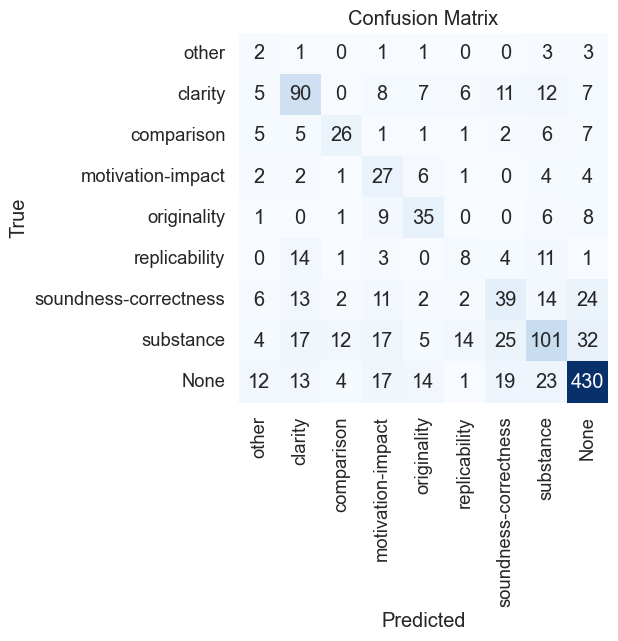

                       precision    recall  f1-score   support

                other       0.05      0.18      0.08        11
              clarity       0.58      0.62      0.60       146
           comparison       0.55      0.48      0.51        54
    motivation-impact       0.29      0.57      0.38        47
          originality       0.49      0.58      0.53        60
        replicability       0.24      0.19      0.21        42
soundness-correctness       0.39      0.35      0.37       113
            substance       0.56      0.44      0.50       227
                 None       0.83      0.81      0.82       533

             accuracy                           0.61      1233
            macro avg       0.44      0.47      0.45      1233
         weighted avg       0.64      0.61      0.62      1233



In [88]:
# Passen Sie die Klassenbezeichnungen an Ihre Kategorien an
class_names = ["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness", "substance", "None"]

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(final_test_labels, pred, target_names=class_names))

In [89]:
# # Passen Sie die Klassenbezeichnungen an Ihre Kategorien an
# class_names = ["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness", "substance", "None"]

# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# print(classification_report(final_test_labels, pred, target_names=class_names))

In [90]:
# # Passen Sie die Klassenbezeichnungen an Ihre Kategorien an
# class_names = ["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness", "substance", "None"]

# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# print(classification_report(final_test_labels, pred, target_names=class_names))


In [91]:
# # Passen Sie die Klassenbezeichnungen an Ihre Kategorien an
# class_names = ["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness", "substance", "None"]

# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# print(classification_report(final_test_labels, pred, target_names=class_names))


In [92]:
# from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

# model = TFDistilBertForSequenceClassification.from_pretrained(save_directory, num_labels=9)
 
# # optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
# # model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

# # tokenizer = RobertaTokenizer.from_pretrained(save_directory, from_pt=True)
# # model = TFRobertaForSequenceClassification.from_pretrained(save_directory, from_pt=True)

In [93]:
# def predict_category(text):
#     predict_input = tokenizer.encode(text,
#     truncation=True,
#     padding=True,
#     return_tensors="tf")
#     output = model(predict_input)[0]
#     prediction_value = tf.argmax(output, axis=1).numpy()[0]
#     return prediction_value

In [94]:
# val_labels[0]
# val_texts

In [95]:
# len(val_texts)

In [96]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns

# pred = []
# for v, y in zip(test_texts, test_labels):
#     #print(predict_category(v), "true: ", y)
#     pred.append(predict_category(v))


# confusion = confusion_matrix(test_labels, pred)
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)
# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
# xticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"], 
# yticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()



In [97]:
# confusion = confusion_matrix(train_labels, pred)
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)
# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
# xticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"], 
# yticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [98]:
# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(test_labels, pred)
# print('Accuracy:', accuracy)


# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(test_labels, pred, average='weighted')
# recall = recall_score(test_labels, pred, average='weighted')
# f1 = f1_score(test_labels, pred, average='weighted')

# print('Precision:', precision)
# print('Recall:', recall)
# print('F1-Score:', f1)

In [99]:
# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(test_labels, pred)
# print('Accuracy:', accuracy)


# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(test_labels, pred, average='weighted')
# recall = recall_score(test_labels, pred, average='weighted')
# f1 = f1_score(test_labels, pred, average='weighted')

# print('Precision:', precision)
# print('Recall:', recall)
# print('F1-Score:', f1)

In [100]:
# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(test_labels, pred)
# print('Accuracy:', accuracy)


# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(test_labels, pred, average='weighted')
# recall = recall_score(test_labels, pred, average='weighted')
# f1 = f1_score(test_labels, pred, average='weighted')

# print('Precision:', precision)
# print('Recall:', recall)
# print('F1-Score:', f1)

In [101]:
# from sklearn.metrics import accuracy_score, precision_score, classification_report
# import numpy as np


# # Umwandlung in NumPy Arrays (falls noch nicht)
# test_labels = np.array(test_labels)
# pred = np.array(pred)

# # Accuracy und Precision pro Klasse berechnen
# unique_classes = np.unique(test_labels)

# # Initialisiere Dictionaries für die Ergebnisse
# accuracy_per_class = {}
# precision_per_class = {}

# for cls in unique_classes:
#     # Filtere die Instanzen für die aktuelle Klasse
#     true_positive = np.sum((test_labels == cls) & (pred == cls))
#     total_class_instances = np.sum(test_labels == cls)
    
#     # Accuracy für diese Klasse
#     accuracy_per_class[cls] = true_positive / total_class_instances
    
#     # Precision für diese Klasse
#     precision_per_class[cls] = precision_score(test_labels, pred, labels=[cls], average=None)[0]

# # Ergebnisse ausgeben
# print("Accuracy per class:")
# for cls, acc in accuracy_per_class.items():
#     print(f"Class {cls}: {acc:.2f}")

# print("\nPrecision per class:")
# for cls, prec in precision_per_class.items():
#     print(f"Class {cls}: {prec:.2f}")

# # Zusätzliche detaillierte Metriken für alle Klassen
# print("\nClassification Report:")
# print(classification_report(test_labels, pred, target_names=[f"Class {cls}" for cls in unique_classes]))
